#### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

Cloning into 'doduo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 37 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), 42.06 KiB | 1.68 MiB/s, done.


In [ ]:
%cd doduo

/content/doduo


In [ ]:
!bash download.sh

--2023-05-29 10:33:29--  https://doduo-data.s3-us-west-2.amazonaws.com/data.tar.gz
Resolving doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)... 52.218.245.249, 52.218.178.17, 52.92.227.186, ...
Connecting to doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)|52.218.245.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106987437 (102M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 102.03M  38.5MB/s    in 2.6s    

2023-05-29 10:33:32 (38.5 MB/s) - ‘data.tar.gz’ saved [106987437/106987437]

./._data
./data/
./data/._msato_cv_4.csv
./data/msato_cv_4.csv
./data/._msato_cv_2.csv
./data/msato_cv_2.csv
./data/._msato_cv_3.csv
./data/msato_cv_3.csv
./data/._msato_cv_1.csv
./data/msato_cv_1.csv
./data/._msato_cv_0.csv
./data/msato_cv_0.csv
./data/._table_col_type_serialized.pkl
./data/table_col_type_serialized.pkl
./data/._sato_cv_3.csv
./data/sato_cv_3.csv
./data

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00


#### Import Modules

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

from transformers.models.auto.processing_auto import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from pandas.errors import SettingWithCopyWarning
import warnings
import random

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import locale
locale.getpreferredencoding = lambda: "UTF-8"


##### Preprocessing Functions

In [ ]:
def create_map_dict_for_labels(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}
  
  return my_dict , my_inv_dict

def given_list(temp,my_inv_dict):
  new_list = []
  for t in temp:
    new_list.append(str(my_inv_dict.get(t)))
  return new_list


def flatten_dataframe_to_list(train_df,val_df):
  '''
  flatten both data and labels to list with the respective dataframes
  as well as do necessary preprocessing actions
  '''
  train_label_list = []
  val_label_list = []
  train_data_list = []
  val_data_list = []

  train_temp_label_list = train_df.labels.tolist()
  for t in train_temp_label_list:
    if len(t)==1:
      train_label_list.append(str(my_inv_dict.get(t[0])) + ' </s>')
    else:
      train_label_list.append(' , '.join( given_list(t,my_inv_dict) ) + ' </s>')


  val_temp_label_list = val_df.labels.tolist()
  for t in val_temp_label_list:
    if len(t)==1:
      val_label_list.append(str(my_inv_dict.get(t[0])) + ' </s>')
    else:
      val_label_list.append(' , '.join( given_list(t,my_inv_dict) ) + ' </s>')

  temp_train_data_list = train_df.data.tolist()
  for t in temp_train_data_list:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    train_data_list.append('multilabel classification: ' + texty)

  temp_val_data_list = val_df.data.tolist()
  for t in temp_val_data_list:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    val_data_list.append('multilabel classification: ' + texty)

  return  train_label_list , val_label_list , train_data_list ,val_data_list 


##### Preprocessing Classes

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.SEED = 42
        self.MODEL_PATH = 't5-base'
        self.TOKENIZER = T5Tokenizer.from_pretrained('google/mt5-small')
        self.SRC_MAX_LENGTH = 180
        self.TGT_MAX_LENGTH = 50
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.OUTPUT_PATH = '/content/T5model_single_column_annotation.pt'
        self.EPOCHS = 10

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, texts,labels):
        super(T5Dataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            self.labels[index], 
            max_length=self.tgt_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }



#### Data Preprocessing

In [ ]:
config = Config()

# load the data 
with open('/content/doduo/data/table_col_type_serialized.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [ ]:
# define a threshold for the training & validation data
train_data_threshold = 150000
validation_data_threshold = 3000


train_df = all_data.get('train').head(train_data_threshold)
val_df = all_data.get('dev').head(validation_data_threshold)
whole_df = all_data.get('train')

In [ ]:
# create a dictionary (and inverse) with respect to labels of df
my_dict , my_inv_dict = create_map_dict_for_labels(whole_df)

for key,value in my_dict.items():
  print(key , value)

0 american_football.football_coach
1 american_football.football_conference
2 american_football.football_player
3 american_football.football_team
4 amusement_parks.park
5 amusement_parks.ride
6 architecture.architectural_structure_owner
7 architecture.building
8 architecture.structure
9 architecture.venue
10 astronomy.asteroid
11 astronomy.astronomical_discovery
12 astronomy.celestial_object
13 astronomy.constellation
14 astronomy.orbital_relationship
15 astronomy.star_system_body
16 automotive.company
17 automotive.model
18 aviation.aircraft_model
19 aviation.aircraft_owner
20 aviation.airline
21 aviation.airport
22 award.award
23 award.award_category
24 award.award_ceremony
25 award.award_discipline
26 award.award_presenting_organization
27 award.competition
28 award.hall_of_fame_inductee
29 award.recurring_competition
30 baseball.baseball_league
31 baseball.baseball_player
32 baseball.baseball_position
33 baseball.baseball_team
34 basketball.basketball_coach
35 basketball.basketball_

In [ ]:
train_label_list, val_label_list, train_data_list, val_data_list =  flatten_dataframe_to_list(train_df,val_df)

print('Length of training-data list : {}'.format(len(train_data_list)))
print('Length of training-label list : {}'.format(len(train_label_list)))

print('Length of validation-data list : {}'.format(len(val_data_list)))
print('Length of validation-label list : {}'.format(len(val_label_list)))

Length of training-data list : 150000
Length of training-label list : 150000
Length of validation-data list : 3000
Length of validation-label list : 3000


In [ ]:
# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data = T5Dataset(texts=train_data_list, labels=train_label_list)
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)

val_data = T5Dataset(texts=val_data_list, labels=val_label_list)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

##### Example of the Dataset

In [ ]:
train_df.head()

,table_id,labels,data,label_ids
0,2728176-1,[organization.organization],Public Against Violence Christian Democratic M...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2728185-1,"[government.political_party, organization.orga...",Communist Party of Czechoslovakia Czech Nation...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,27282030-1,"[sports.sports_team, soccer.football_team, org...",North Hobart Glenorchy Clarence Sandy Bay Hoba...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2728219-1,"[location.administrative_division, location.lo...",Atlantic Bergen Burlington Camden Cape May Cum...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2728231-1,[film.film],Bottle Rocket Rushmore The Royal Tenenbaums Bo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_data_list[1]

"multilabel classification: communist party of czechoslovakia czech national social party czechoslovak people's party democratic party czechoslovak social democracy communist party of slovakia freedom party labour party"

In [ ]:
train_label_list[1]

'121 , 191 </s>'

In [ ]:
train_df[train_df.table_id.str.contains('2728176-1')]

,table_id,labels,data,label_ids
0,2728176-1,[organization.organization],Public Against Violence Christian Democratic M...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_data_list[0]

'multilabel classification: public against violence christian democratic movement slovak national party communist party of slovakia coexistence – hungarian christian democratic movement democratic party party of greens freedom party czechoslovakian socialist party'

In [ ]:
train_label_list[0]

'191 </s>'

In [ ]:
config.TOKENIZER.decode(train_data[0].get('src_input_ids'))

'multilabel classification: public against violence christian democratic movement slovak national party communist party of slovakia coexistence – hungarian christian democratic movement democratic party party of greens freedom party czechoslovakian socialist party</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

#### Data Visualizations

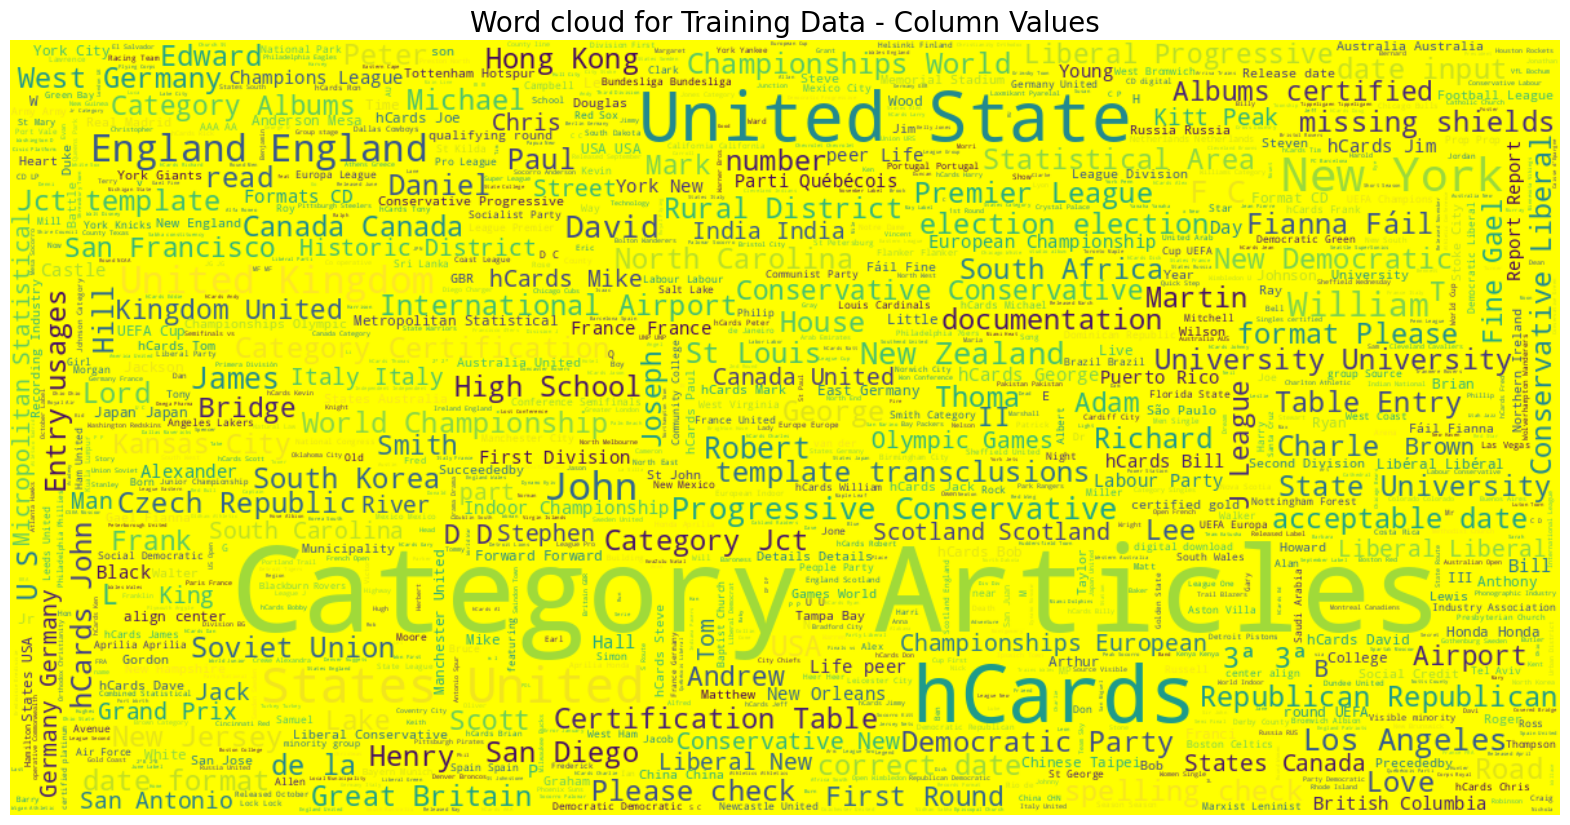

In [ ]:
# WordCloud

train_data_ex = train_df['data']
train_data_ex_string = ' '.join(train_data_ex)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="yellow",stopwords=STOPWORDS).generate(train_data_ex_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Training Data - Column Values',fontsize = 20)
plt.show()


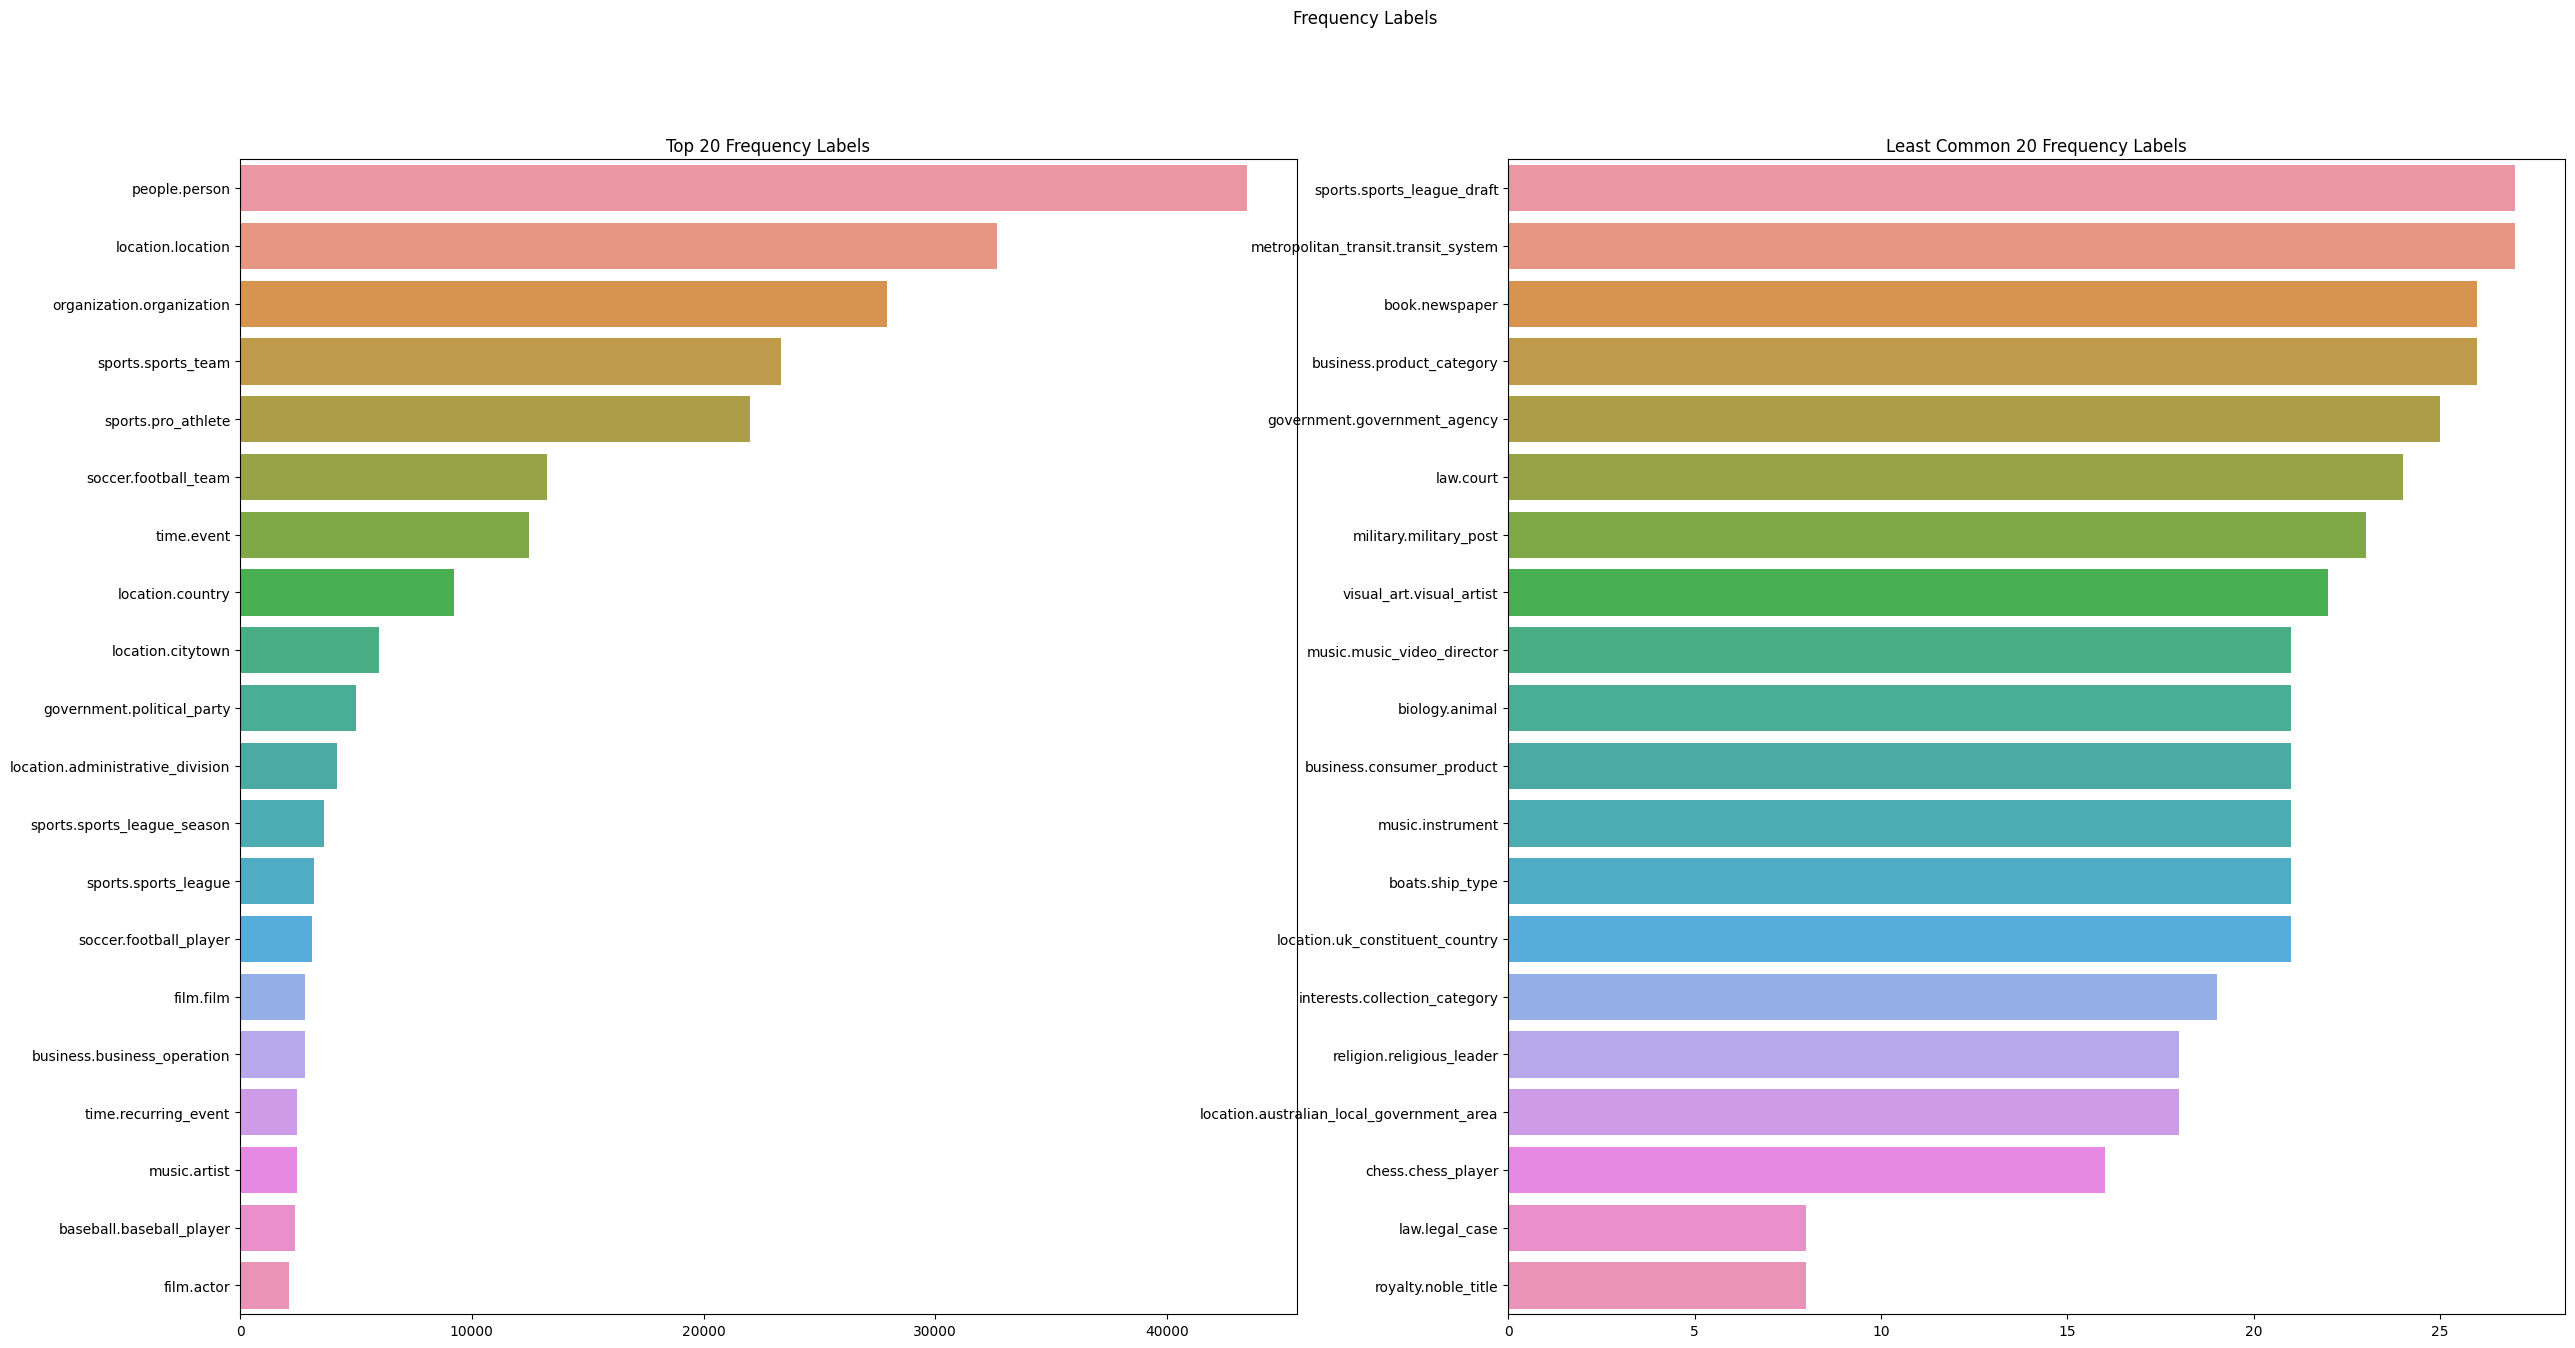

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))

sns.barplot(y=train_df_value_counts.head(20).index, x=train_df_value_counts.head(20).values,ax=ax1)
sns.barplot(y=train_df_value_counts.tail(20).index, x=train_df_value_counts.tail(20).values,ax=ax2)

ax1.set_title('Top 20 Frequency Labels')
ax2.set_title('Least Common 20 Frequency Labels')
fig.suptitle('Frequency Labels')
plt.show()

##### Tokenizer Length Distribution

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


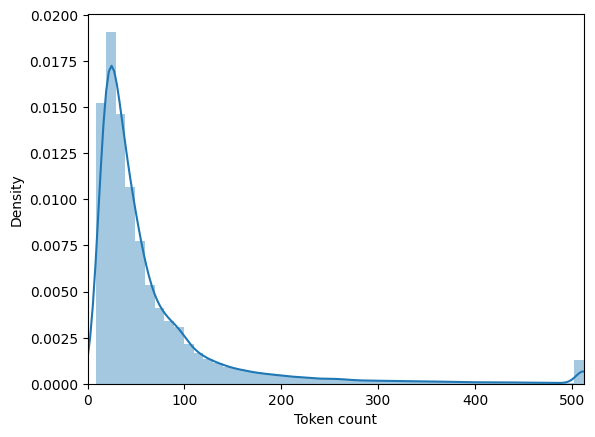

In [ ]:
tmp_tokenizer = config.TOKENIZER

token_lens = []

for txt in train_data_list:
  tokens = tmp_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

#### T5 Training

##### Training Classes

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()
        self.t5_model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

##### Training Functions

In [ ]:
def convert_to_ohe(temp_list):
  '''
  Convert predicted list , with target values, to 
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 255
  '''
  global_list = []
  for temp_batch in temp_list:
    base = 255*[0]
    temp_list_decomp= temp_batch.split(',')
    for l in temp_list_decomp:
      if l is None or l.strip() =='':
        continue
      else:
        temp = l.strip()
      if int(temp) in my_dict.keys():
        base[ int(temp) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)


In [ ]:
def val(model, val_dataloader, criterion):
    '''
    The function that is utilized to the validation phase
    with th respective dataloader
    '''
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id,skip_special_tokens=True)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True)
                pred.append(pred_decoded)

    true_ohe = convert_to_ohe(true)
    pred_ohe = convert_to_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score , avg_val_loss


def train(
    model,  
    train_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    '''
    The function that is utilized to the training phase
    with th respective dataloader
    '''
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    return model , avg_train_loss

In [ ]:
# define the model 
# and move from CPU to GPU

device = config.DEVICE
model = T5Model()
model.to(device);

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
# define the parameters to be optmized 
torch.manual_seed(config.SEED)
criterion = nn.BCEWithLogitsLoss()

if config.FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

num_training_steps = len(train_dataloader) * config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

# set the max val F1-score
max_val_micro_f1_score = float('-inf')

# run across the Epochs
for epoch in range(config.EPOCHS):
    model ,avg_train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, epoch)
    val_micro_f1_score , avg_val_loss = val(model, val_dataloader, criterion)
    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)
    if config.SAVE_BEST_ONLY:
        # save and overwrite only the best model
        # with the highest F1 score in validation
        if val_micro_f1_score > max_val_micro_f1_score:
            max_val_micro_f1_score = val_micro_f1_score
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(),config.OUTPUT_PATH)
            print(f'Best F1-score in Validation : {max_val_micro_f1_score}')


Epoch 0:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 3.449252465292613
Val loss: 1.461866280816971
Val accuracy: 0.077
Val micro f1 score: 0.27684762387958733
Best F1-score in Validation : 0.27684762387958733


Epoch 1:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 1.2667691324170431
Val loss: 0.9814096235848487
Val accuracy: 0.22866666666666666
Val micro f1 score: 0.48810791622293215
Best F1-score in Validation : 0.48810791622293215


Epoch 2:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.8523570681689183
Val loss: 0.7065994614299308
Val accuracy: 0.357
Val micro f1 score: 0.6305912362211896
Best F1-score in Validation : 0.6305912362211896


Epoch 3:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.6797635851573944
Val loss: 0.5995956542802617
Val accuracy: 0.41
Val micro f1 score: 0.6699813548788067
Best F1-score in Validation : 0.6699813548788067


Epoch 4:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.5991424690757692
Val loss: 0.5411876709140996
Val accuracy: 0.447
Val micro f1 score: 0.7008486562942009
Best F1-score in Validation : 0.7008486562942009


Epoch 5:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.5517287386725843
Val loss: 0.5024266449060846
Val accuracy: 0.4716666666666667
Val micro f1 score: 0.7177526891279224
Best F1-score in Validation : 0.7177526891279224


Epoch 6:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.5214943656075001
Val loss: 0.48020518464135364
Val accuracy: 0.484
Val micro f1 score: 0.7245349867139061
Best F1-score in Validation : 0.7245349867139061


Epoch 7:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.502300362902085
Val loss: 0.46198354209674164
Val accuracy: 0.495
Val micro f1 score: 0.73368700265252
Best F1-score in Validation : 0.73368700265252


Epoch 8:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.4904705453513811
Val loss: 0.4549797786439353
Val accuracy: 0.499
Val micro f1 score: 0.7372500660618339
Best F1-score in Validation : 0.7372500660618339


Epoch 9:   0%|          | 0/9375 [00:00<?, ?it/s]

Training loss: 0.4846965913965305
Val loss: 0.45103130541107755
Val accuracy: 0.5036666666666667
Val micro f1 score: 0.7414557787633708
Best F1-score in Validation : 0.7414557787633708


##### Training Graph of the model 

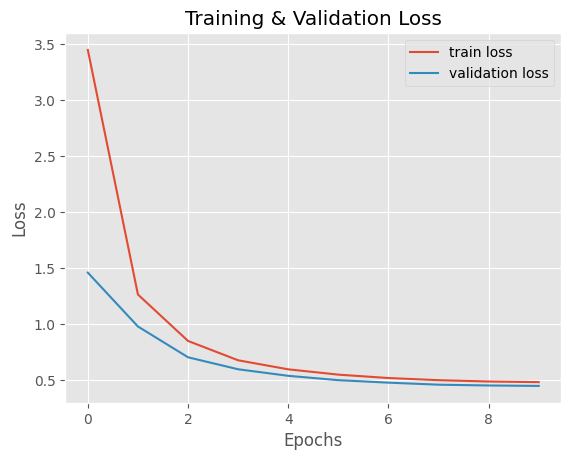

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = config.EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list, label="train loss")
plt.plot(np.arange(0, N), avg_val_loss_list, label="validation loss")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

##### Save the Model to Drive

In [ ]:
! cp -r /content/T5model_single_column_annotation.pt /content/drive/MyDrive/'Colab Notebooks'/Databases/T5_models

#### Loading the Model & Inference Examples

In [ ]:
load_T5_model = T5Model()
load_T5_model.to(config.DEVICE);
load_T5_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Databases/T5_models/T5model_single_column_annotation.pt'))

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


<All keys matched successfully>

In [ ]:
inference_val_dataloader = DataLoader(val_data, batch_size=1)

#### Inference Functions

In [ ]:
def convert_to_true_labels(inv_dict_labels):
  '''
  Convert from inv-dict labels to 
  true labels
  '''
  gen = []
  inv_dict_labels_list = inv_dict_labels.split(' ')
  for l in inv_dict_labels_list:
    if l is not None or l != '':
      if int(l) in my_dict.keys():
        gen.append(my_dict.get(int(l)))
  return ' & '.join(gen)

def inference_single_example(temp_model,temp_batch):
  '''
  With respect to a model and batch we make inference for a single example 
  '''

  b_src_input_ids = temp_batch['src_input_ids'].to(config.DEVICE)
  b_src_attention_mask = temp_batch['src_attention_mask'].to(config.DEVICE)
  pred_ids = temp_model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )

  pred_ids = pred_ids.cpu().numpy()
  for pred_id in pred_ids:
      pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")

  return pred_decoded

#### Inference Examples

In [ ]:
# Generate 2 random int for examples
random_list = random.sample(range(1, 100), 2)
print('Generate random indexes {} '.format(random_list))
print()

counter =0
for index, batch in enumerate(inference_val_dataloader):
  if index in random_list:
    print('Example {}'.format(counter))
    print('Data : {}'.format(config.TOKENIZER.decode(batch.get('src_input_ids')[0],skip_special_tokens=True)))
    inv_dict_labels = config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")
    print('True Inv-Dict Labels : {}'.format(config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")))
    print('True Labels : {}'.format(convert_to_true_labels(inv_dict_labels)))

    inference_ex_labels = inference_single_example(temp_model=load_T5_model,temp_batch=batch)
    print('Predicted Inv-Dict Labels : {}'.format(inference_ex_labels))
    print('Predicted Labels : {}'.format(convert_to_true_labels(inference_ex_labels)))

    print()
    counter = counter +1

Generate random indexes [91, 3] 

Example 0
Data : multilabel classification: esteghlal ahvaz tractor sazi tractor sazi saba pas hamedan
True Inv-Dict Labels : 231 210 191
True Labels : sports.sports_team & soccer.football_team & organization.organization
Predicted Inv-Dict Labels : 231 210 191
Predicted Labels : sports.sports_team & soccer.football_team & organization.organization

Example 1
Data : multilabel classification: bruce alexander desmond barrit tobias menzies diane fletcher marc elliott jamie king matt smith steven webb thomas morrison
True Inv-Dict Labels : 242 194
True Labels : tv.tv_actor & people.person
Predicted Inv-Dict Labels : 194
Predicted Labels : people.person

